In [39]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd

# for loading wrf
from glob import glob
from netCDF4 import Dataset
import wrf

ena = {'lat': 39, 'lon': 360 - 28}
ena_wrf = {'south_north': 59, 'west_east': 60}  # index of WRF grid location closest to ENA site ~(28W, 39N)

In [44]:
the_date = '2018-01-19'

# Comparison of ERA5 and WRF output at ENA site for Jan 19, 2018 case
Location is approximately (39N, 28W). Observation site (Santa Cruz Da Graciosa) is on NW tip of the island.

### Observational sets from ARM

* `enainterpolatedsonde`: time-height of atmospheric state estimated from radiosondes connected in time via surface meteorology and microwave radiometer estimated total column water vapor observations
  * `temp`, `potential_temp`
  * `rh`, `rh_scaled` (using MWR ... not sure which is better)
  * `u_wind`, `v_wind`
* `enaaafnaviwg`: atmospheric state measurements from the aircraft
* `enarlprof`: remote sensing estimated low level temperature and humidity (Raman lidar)
  * `cbh` (cloud base height)
* `enadlprof`: remote sensing estimated winds (Doppler lidar)

In [40]:
arm_topdir = '/Users/jone003/Dropbox/EAGLES/arm_data'
ds_sonde = xr.open_dataset(f'{arm_topdir}/enainterpolatedsondeC1.c1.20180119.000030.nc')
ds_aaf = xr.open_dataset(f'{arm_topdir}/enaaafnaviwgF1.c1.20180119.121131.nc')
ds_rlprof = xr.open_dataset(f'{arm_topdir}/enarlprofmr2news10mC1.c0.20180119.000500.nc')
# do not have this set - double check
# ds_dlprof = xr.open_dataset(f'{arm_topdir}/enadlprofwind4newsC1.c1.20170718.000035.nc')

In [41]:
# combine into hourly-averaged product
sonde_variables = ['temp', 'potential_temp', 'sh', 'rh', 'rh_scaled', 'u_wind', 'v_wind']
ds_obs = xr.merge([ds_sonde[sonde_variables].resample(time='1H').mean(), ds_rlprof['cbh'].resample(time='1H').mean()])
ds_obs

/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:         (height: 332, time: 24)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-19 ... 2018-01-19T23:00:00
  * height          (height) float32 0.03048 0.05048 ... 40.510487 41.010487
Data variables:
    temp            (time, height) float32 15.859089 15.836555 ... nan nan
    potential_temp  (time, height) float32 286.71686 286.888 ... nan nan
    sh              (time, height) float32 0.009260805 0.009136655 ... nan nan
    rh              (time, height) float32 84.53613 83.33337 ... nan nan
    rh_scaled       (time, height) float32 84.53613 83.33337 ... nan nan
    u_wind          (time, height) float32 -0.037441667 0.007021032 ... nan nan
    v_wind          (time, height) float32 1.7470783 2.070583 ... nan nan
    cbh             (time) float32 0.92 0.9299999 ... 0.92749995 0.88374996

### WRF

In [42]:
wrf_output = sorted(glob('/Users/jone003/tmp/EAGLES/WRF/output_wrf/ena_2018_01_19/wrfout*'))
wrf_in = [Dataset(f) for f in wrf_output]

In [43]:
lat = wrf.getvar(wrf_in, 'lat', timeidx=wrf.ALL_TIMES, method="cat")
lon = wrf.getvar(wrf_in, 'lon', timeidx=wrf.ALL_TIMES, method='cat')
temp = wrf.getvar(wrf_in, 'tc', timeidx=wrf.ALL_TIMES, method='cat')
theta = wrf.getvar(wrf_in, 'theta', timeidx=wrf.ALL_TIMES, method='cat')
z = wrf.getvar(wrf_in, 'z', timeidx=wrf.ALL_TIMES, method='cat')
rh = wrf.getvar(wrf_in, 'rh', timeidx=wrf.ALL_TIMES, method='cat')
u = wrf.getvar(wrf_in, 'ua', timeidx=wrf.ALL_TIMES, method='cat')
v = wrf.getvar(wrf_in, 'va', timeidx=wrf.ALL_TIMES, method='cat')
cloudfrac = wrf.getvar(wrf_in, 'cloudfrac', timeidx=wrf.ALL_TIMES, method='cat')

qvapor = wrf.getvar(wrf_in, 'QVAPOR', timeidx=wrf.ALL_TIMES, method='cat')
qcloud = wrf.getvar(wrf_in, 'QCLOUD', timeidx=wrf.ALL_TIMES, method='cat')
qrain = wrf.getvar(wrf_in, 'QRAIN', timeidx=wrf.ALL_TIMES, method='cat')
qice = wrf.getvar(wrf_in, 'QICE', timeidx=wrf.ALL_TIMES, method='cat')
q = qvapor / (1 + qvapor)  # specific humidity
cld = wrf.getvar(wrf_in, 'CLDFRA', timeidx=wrf.ALL_TIMES, method='cat')

In [45]:
ds_wrf = xr.Dataset({'temp': temp,
                     'u_wind': u,
                     'v_wind': v,
                     'sh': q,
                     'potential_temp': theta,
                     'height': z / 1000,
                     'cloudfrac': cloudfrac,
                     'qvapor': qvapor,
                     'qcloud': qcloud,
                     'qice': qice,
                     'qrain': qrain,
                     'rh': rh,
                     'cld': cld}
                   )
ds_wrf_ena = ds_wrf.isel(**ena_wrf).sel(Time=the_date)

### reanalysis
no need to load everything, select subset of lats/lons

In [56]:
ds_era = xr.open_dataset('/Users/jone003/tmp/EAGLES/ERA5_ENA_20180116-20180126_with_height_and_presl.nc').sel(lat=slice(40, 38), lon=slice(331, 333), time=the_date)
ds_era

<xarray.Dataset>
Dimensions:                (lat: 9, lev: 137, lon: 9, time: 24)
Coordinates:
  * time                   (time) datetime64[ns] 2018-01-19 ... 2018-01-19T23:00:00
  * lat                    (lat) float32 40.0 39.75 39.5 ... 38.5 38.25 38.0
  * lon                    (lon) float32 331.0 331.25 331.5 ... 332.75 333.0
  * lev                    (lev) float32 1.0 2.0 3.0 4.0 ... 135.0 136.0 137.0
Data variables:
    TMP                    (time, lev, lat, lon) float32 ...
    SPFH                   (time, lev, lat, lon) float32 ...
    UGRD                   (time, lev, lat, lon) float32 ...
    VGRD                   (time, lev, lat, lon) float32 ...
    GP                     (time, lat, lon) float32 ...
    NLPRES                 (time, lat, lon) float32 ...
    initial_time0_encoded  (time) float64 ...
    initial_time0          (time) |S18 ...
    height                 (lev, time, lat, lon) float64 ...
    pressure               (lev, time, lat, lon) float64 ...
Attrib

In [57]:
zobs = ds_sonde['height']
height = ds_era['height']  # dims ('lev', 'time', 'lat', 'lon')

In [58]:
# optionally interpolate ds_era to same height levels as obs ds
# should make it easier to compare directly, but not really needed if just plotting
def interp_to_height(ds_era, height_obs):
    height = ds_era['height'].transpose('time', 'lev', 'lat', 'lon')  # originally (lev, time, lat, lon)
    height = height[:, ::-1, :, :]  # ordered as increasing height
    ax0 = height.dims.index('lev')
    
    var_list = [v for v in ds_era if 'lev' in ds_era[v].dims]  # time, lev, lat, lon
    
    time = ds_era.time.values
    lat = ds_era.lat.values
    lon = ds_era.lon.values
    ntime = len(time)
    nlat = len(lat)
    nlon = len(lon)
    nheight = len(height_obs)
    out_shape = (ntime, nheight, nlat, nlon)
    
    ds_out = xr.Dataset()
    ds_out['height'] = height_obs
    # easiest to just loop over columns (even if that feels dumb)
    # new output has shape time, nheight, nlat, nlon
    for v in var_list:
        print(v)
        if v == 'height':
            continue
        # note: need to reverse order so height increases
        arr_in = ds_era[v].transpose('time', 'lev', 'lat', 'lon').values[:, ::-1, :, :]
        arr_out = np.full(out_shape, np.nan)
        print(arr_out.shape)
        print(arr_in.shape)
        for jt in range(ntime):
            for jlat in range(nlat):
                for jlon in range(nlon):
                    arr_out[jt, :, jlat, jlon] = np.interp(height_obs.values,
                                                           height[jt, :, jlat, jlon],
                                                           arr_in[jt, :, jlat, jlon])
        da = xr.DataArray(arr_out, coords=[time, height_obs, lat, lon],
                          dims=['time', 'height', 'lat', 'lon'],
                          name=v,
                          attrs=ds_era[v].attrs)
        ds_out[v] = da.copy(deep=True)
    return ds_out

In [59]:
ds_era_height = interp_to_height(ds_era, zobs)
# ds_era_height

TMP
(24, 332, 9, 9)
(24, 137, 9, 9)
SPFH
(24, 332, 9, 9)
(24, 137, 9, 9)
UGRD
(24, 332, 9, 9)
(24, 137, 9, 9)
VGRD
(24, 332, 9, 9)
(24, 137, 9, 9)
height
pressure
(24, 332, 9, 9)
(24, 137, 9, 9)


In [60]:
era_theta = ds_era_height['TMP'] * (1000 * 100 / ds_era_height['pressure']) ** (0.286)
era_theta.attrs = {'units': 'K', 'long_name': 'potential temperature'}
ds_era_height['potential_temp'] = era_theta
# ds_era_height

In [63]:
# for initial comparison, select lat, lon = (39, -28)
ds_era_ena = ds_era.sel(**ena, time=the_date)
if 'lev' in ds_era_height:
    ds_era_height_ena = ds_era_height.drop('lev').sel(**ena, time=the_date)
else:
    ds_era_height_ena = ds_era_height.sel(**ena, time=the_date)

In [64]:
ds_era_height_ena

<xarray.Dataset>
Dimensions:         (height: 332, time: 24)
Coordinates:
  * height          (height) float32 0.03048 0.05048 ... 40.510487 41.010487
  * time            (time) datetime64[ns] 2018-01-19 ... 2018-01-19T23:00:00
    lat             float32 39.0
    lon             float32 332.0
Data variables:
    TMP             (time, height) float64 289.2 289.0 288.8 ... 266.6 267.0
    SPFH            (time, height) float64 0.008824 0.008771 ... 3.774e-06
    UGRD            (time, height) float64 2.153 2.229 2.274 ... 17.09 16.71
    VGRD            (time, height) float64 4.239 4.368 4.443 ... 30.46 28.9
    pressure        (time, height) float64 1.029e+05 1.027e+05 ... 257.2 241.3
    potential_temp  (time, height) float64 286.8 286.8 ... 1.467e+03 1.497e+03

# 2D plots

In [65]:
# join era and obs:
ds1 = ds_era_height_ena.rename({'TMP': 'temp',
                                'UGRD': 'u_wind',
                                'VGRD': 'v_wind',
                                'SPFH': 'sh'}).drop(['lat', 'lon'])
if ds1['temp'].min() > 50:
    # convert to celsius
    ds1['temp'].values = ds1['temp'].values - 273.15

### examine `qcloud`
I am concerned that there is no cloud ...

In [66]:
qcld_wrf = ds_wrf_ena.qcloud.values
is_cloud = qcld_wrf > 0
np.count_nonzero(is_cloud)

178

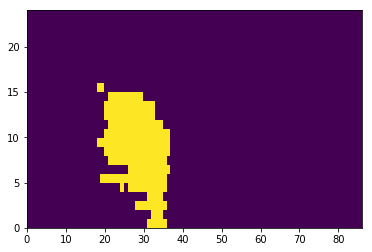

In [67]:
plt.pcolor(is_cloud)

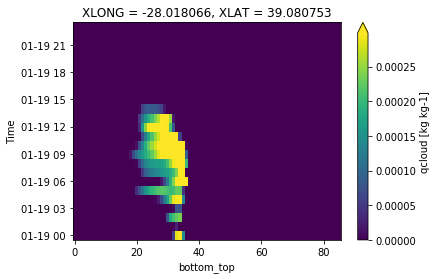

In [68]:
ds_wrf_ena.qcloud.plot(robust=True)

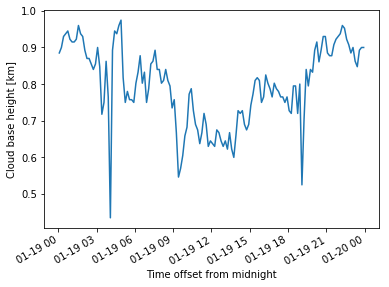

In [69]:
# cloud base height hovers around 500-700m throughout, deepening over time
# some missing data over the last few hours
ds_rlprof['cbh'].plot()
cbh_mask = ds_rlprof['cbh'] > 0

In [74]:
# plot time-height of cloud fraction from WRF vs. cbh from obs
zrange = slice(0, 40)
zx = ds_wrf_ena.height.isel(bottom_top=zrange)
cldx = ds_wrf_ena.cld.isel(bottom_top=zrange)
tx = ds_wrf_ena.Time

# ds_obs.cbh

Text(0, 0.5, 'height [km]')

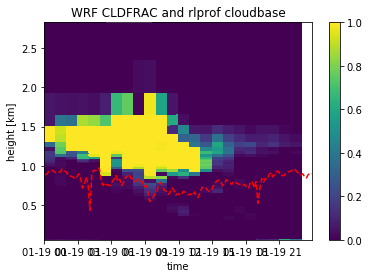

In [75]:
plt.pcolormesh(tx.broadcast_like(zx), zx, cldx, vmin=0, vmax=1)

# add cloudbase height from rl_prof
cbh = ds_rlprof['cbh'].where(cbh_mask)
plt.plot(ds_rlprof.time, cbh, 'r--')
plt.colorbar()
plt.title('WRF CLDFRAC and rlprof cloudbase')
plt.xlabel('time')
plt.ylabel('height [km]')

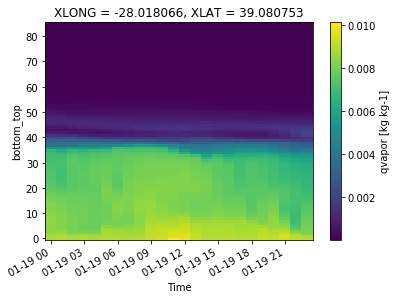

In [76]:
ds_wrf_ena.qvapor.plot(x='Time')

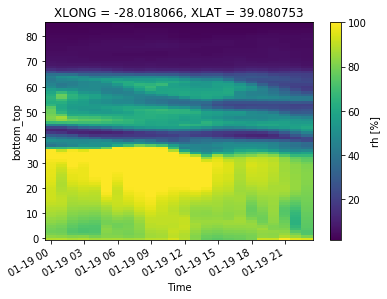

In [77]:
ds_wrf_ena.rh.plot(x='Time')

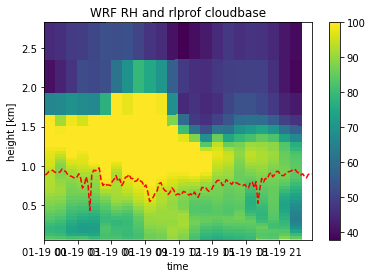

In [78]:
plt.pcolormesh(tx.broadcast_like(zx), zx, ds_wrf_ena.rh.isel(bottom_top=zrange))

# add cloudbase height from rl_prof
cbh = ds_rlprof['cbh'].where(cbh_mask)
plt.plot(ds_rlprof.time, cbh, 'r--')
plt.colorbar()
plt.title('WRF RH and rlprof cloudbase')
plt.xlabel('time')
plt.ylabel('height [km]');

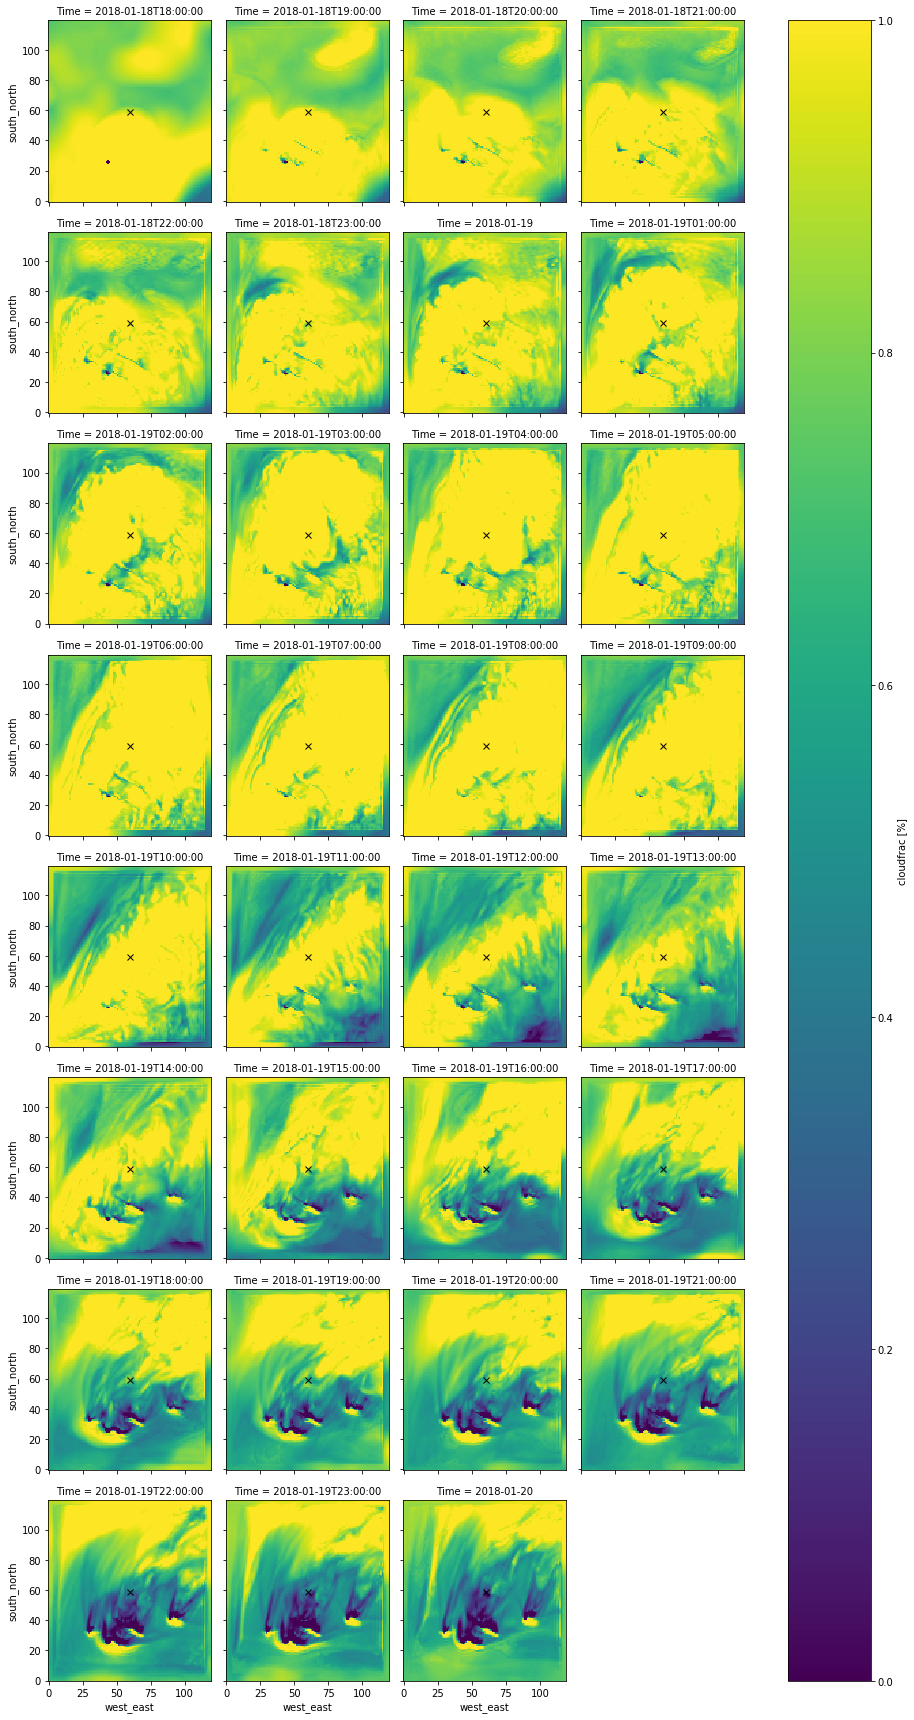

In [79]:
# low cloud fraction
p = ds_wrf.cloudfrac.isel(low_mid_high=0).plot(col='Time', col_wrap=4)
for ax in p.axes.flat:
    ax.plot(ena_wrf['west_east'], ena_wrf['south_north'], 'kx')

## Relative humidity profiles with cloud base
Looks like layer decouples around 10:00.

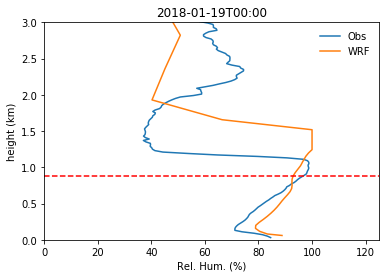

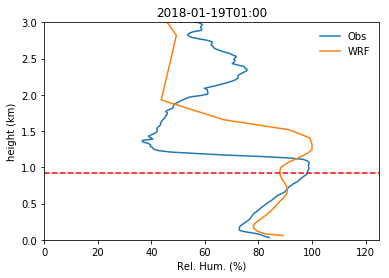

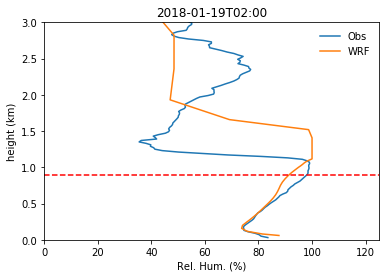

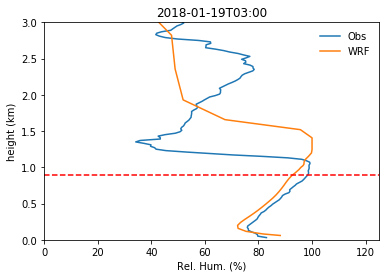

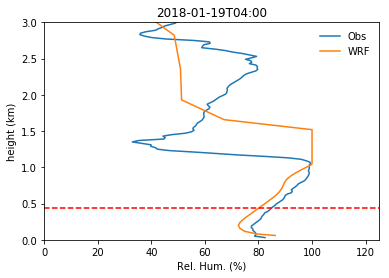

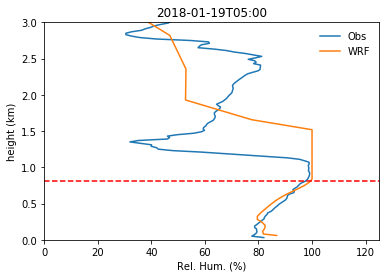

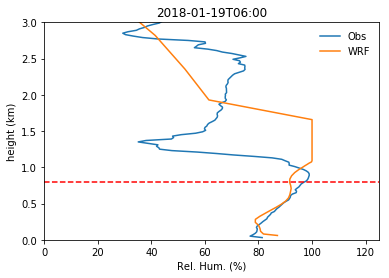

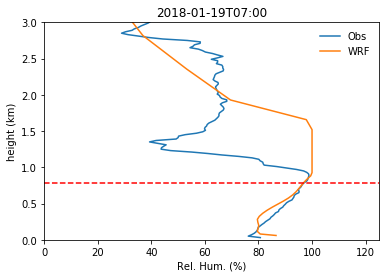

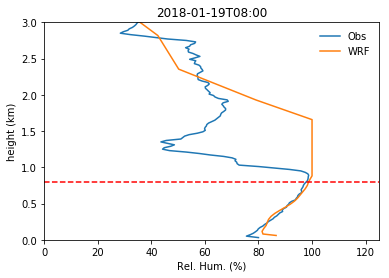

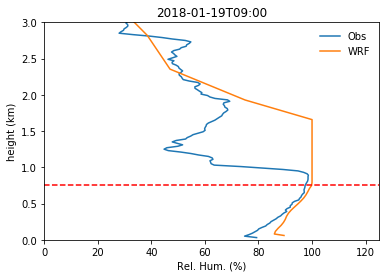

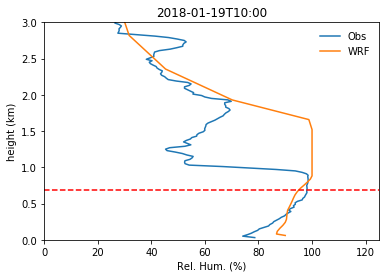

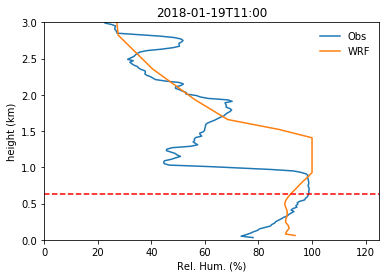

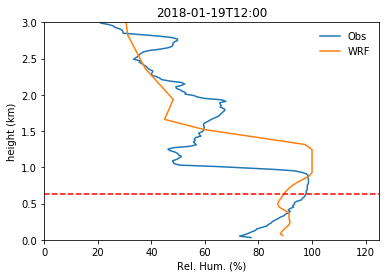

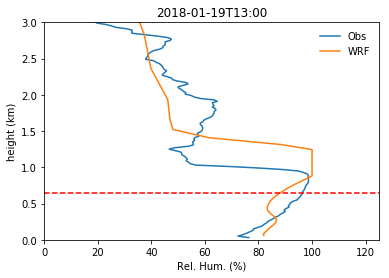

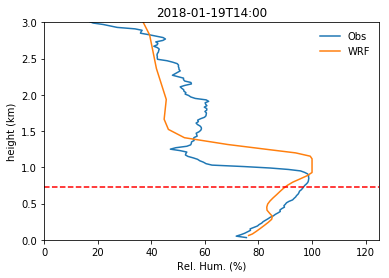

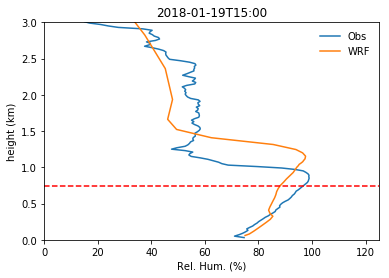

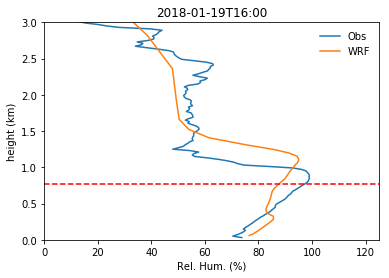

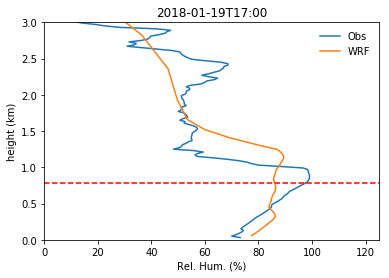

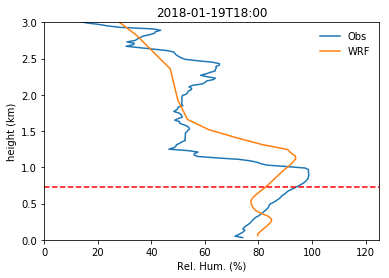

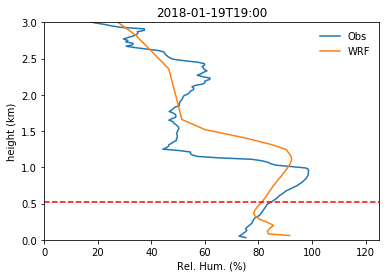

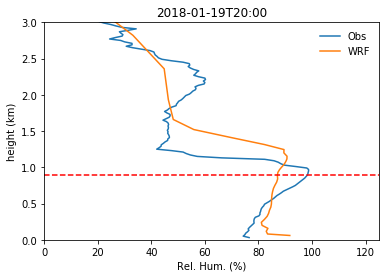

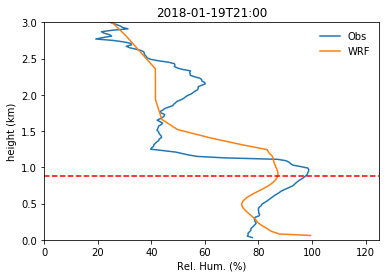

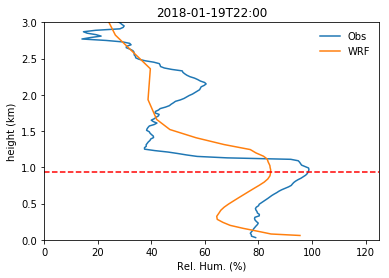

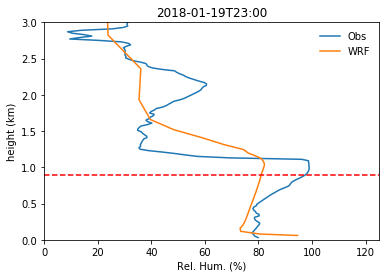

In [80]:
z = ds1.height
xlims = (0, 125)
ylims = (0, 3)
ylab = 'height (km)'
xlab = 'Rel. Hum. (%)'
for n in range(len(ds_obs.time)):
    cb = cbh.sel(time=ds_obs.time[n], method='nearest')
    fig, ax = plt.subplots()
    ax.plot(ds_obs['rh'].isel(time=n), z)
    ax.plot(ds_wrf_ena['rh'].isel(Time=n), ds_wrf_ena.height.isel(Time=n))
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.plot(xlims, [cb, cb], 'r--')
    ax.legend(['Obs', 'WRF'], frameon=False)
    ax.set_ylabel(ylab)
    the_title = np.datetime_as_string(ds_obs.time.values[n], unit='m')
    ax.set_title(the_title)
    ax.set_xlabel(xlab)
    plt.show()

## More profiles
Profiles of temperature, potential temperature, specific humidity, and winds.

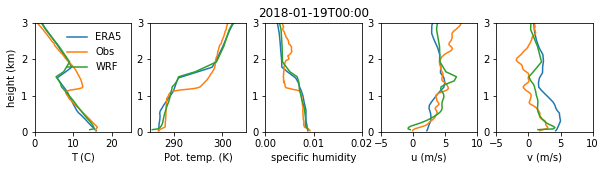

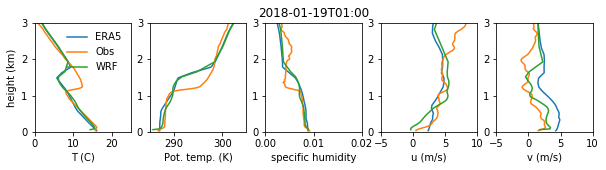

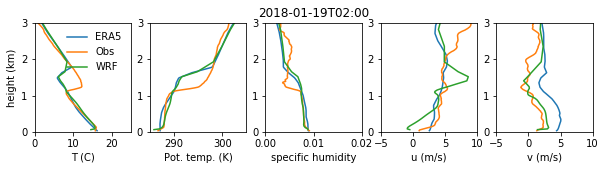

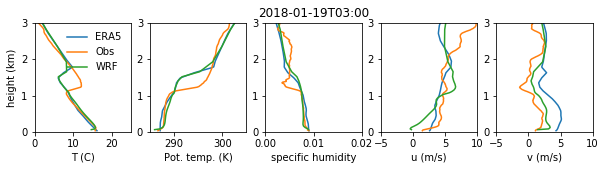

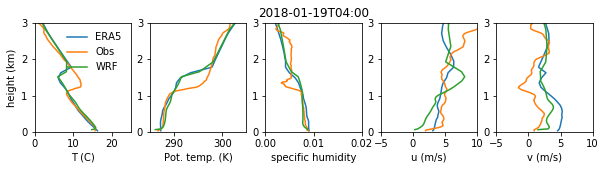

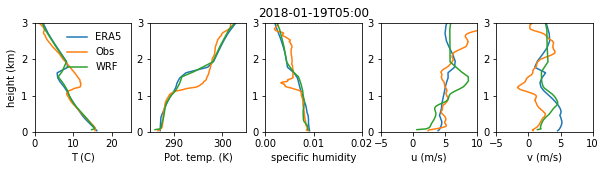

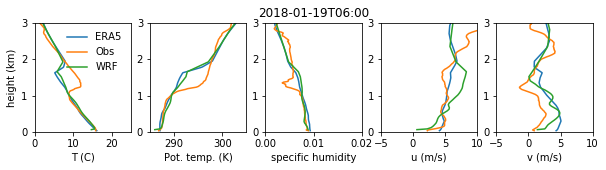

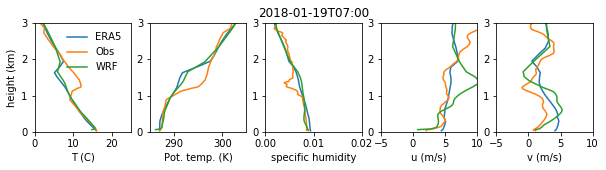

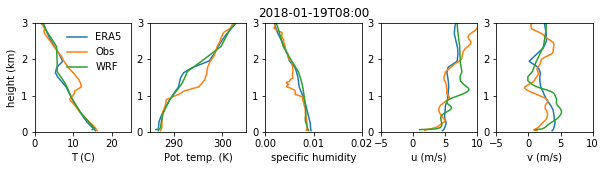

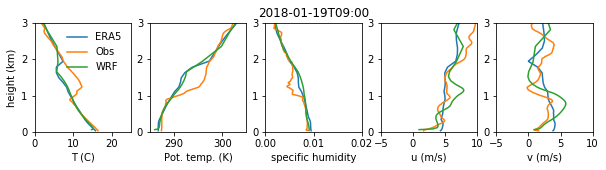

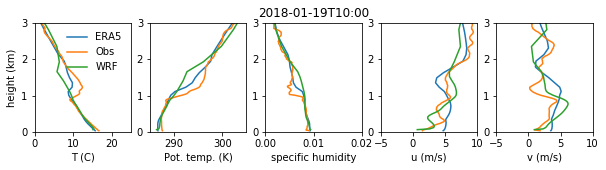

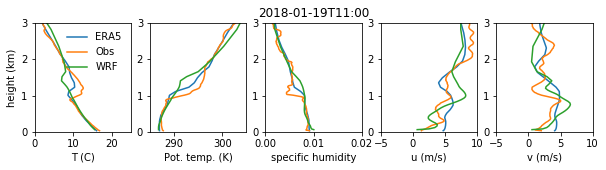

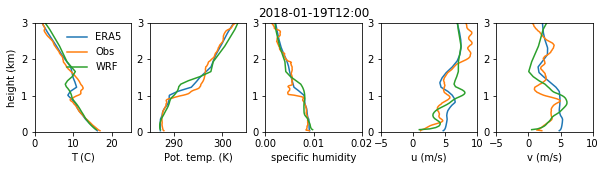

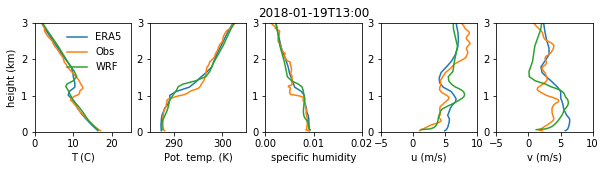

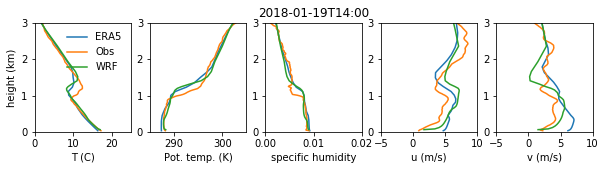

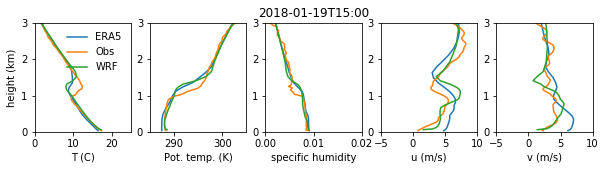

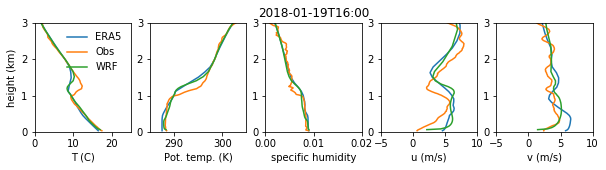

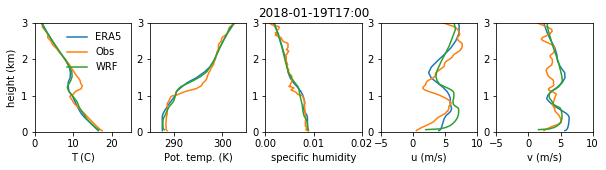

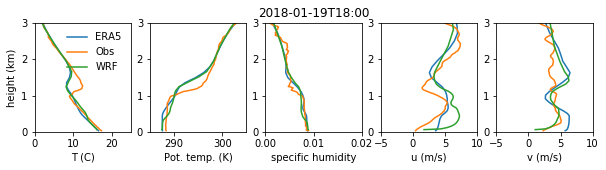

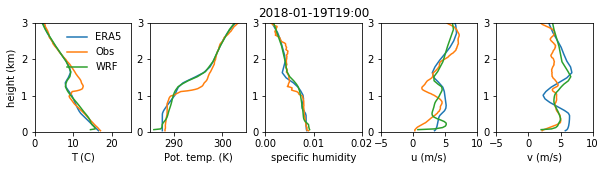

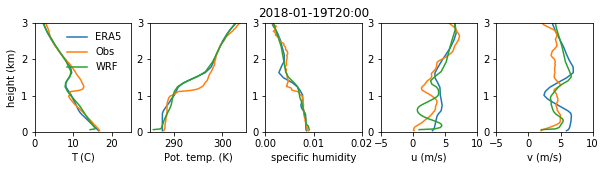

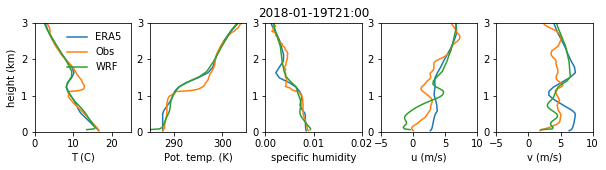

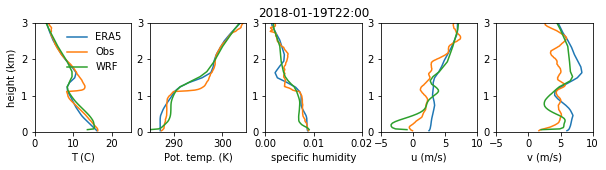

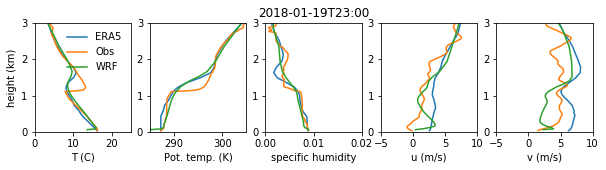

In [83]:
# make a long set of plots:
# all together: 
#    fig, axes = plt.subplots(ncols=5, nrows=24, figsize=(8, 48)
# but it looks better if they're all separate instead

save_fig = False
z = ds1.height
ylims = [0, 3]
xlims = [(0, 25), (285, 305), (0, 0.02), (-5, 10), (-5, 10)]
ylab = 'height (km)'
xlab = ['T (C)', 'Pot. temp. (K)', 'specific humidity', 'u (m/s)', 'v (m/s)']
for n in range(len(ds1.time)):
    cb = cbh.sel(time=ds1.time[n], method='nearest')
    fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(10, 2))
    for j, v in enumerate(['temp', 'potential_temp', 'sh', 'u_wind', 'v_wind']):
        ax = axes[j]
        ax.plot(ds1[v].isel(time=n), z)
        ax.plot(ds_obs[v].isel(time=n), z)
        ax.plot(ds_wrf_ena[v].isel(Time=n), ds_wrf_ena.height.isel(Time=n))
        ax.set_ylim(ylims)
        ax.set_xlim(xlims[j])
        # ax.plot(xlims[j], [cb, cb], 'r--')
        if (j == 0):
            ax.legend(['ERA5', 'Obs', 'WRF'], frameon=False)
        if j == 0:
            ax.set_ylabel(ylab)
        if j == 2:
            the_title = np.datetime_as_string(ds1.time.values[n], unit='m')
            ax.set_title(the_title)
        ax.set_xlabel(xlab[j])
    if save_fig:
        out_name = f'era5_v_wrf_v_obs_ena_20170718_v2_{n:02}.png'
        fig.savefig(out_name)
    plt.show()

# Extras

## dataset contents

In [26]:
def print_var_info(v, ds):
    """Print relevant attribute info about variable v in dataset ds"""
    attrs = ds[v].attrs
    long_name = attrs.get('long_name', '')
    units = attrs.get('units', '')
    standard_name = attrs.get('standard_name', '')
    dims = ','.join(ds[v].dims)
    print(f'{v} ({dims}): {long_name} [{units}]\n\t{standard_name}')

In [27]:
for v in ds_sonde:
    print_var_info(v, ds_sonde)

base_time (): Base time in Epoch []
	
time_offset (time): Time offset from base_time []
	
precip (time): Precipitation [mm]
	lwe_thickness_of_precipitation_amount
qc_precip (time): Quality check results on field: Precipitation [unitless]
	
temp (time,height): Temperature [degC]
	air_temperature
qc_temp (time,height): Quality check results on field: Temperature [unitless]
	
source_temp (time,height): Source for field: Temperature [unitless]
	
rh (time,height): Relative humidity [%]
	relative_humidity
qc_rh (time,height): Quality check results on field: Relative humidity [unitless]
	
source_rh (time,height): Source for field: Relative humidity [unitless]
	
vap_pres (time,height): Vapor pressure [kPa]
	water_vapor_partial_pressure_in_air
qc_vap_pres (time,height): Quality check results on field: Vapor pressure [unitless]
	
bar_pres (time,height): Barometric pressure [kPa]
	air_pressure
qc_bar_pres (time,height): Quality check results on field: Barometric pressure [unitless]
	
source_bar_p

In [28]:
for v in ds_aaf:
    print_var_info(v, ds_aaf)

base_time (): Base time in Epoch []
	
time_offset (time): Time offset from base_time []
	
wgs_alt (time): Altitude above the ellipsoid based on WGS-84 [m]
	altitude
press_alt (time): Altitude calculated from US standard atmospheric tables [m]
	altitude
radar_alt (time): Altitude calculated using GPS altitude and position with the Digital Terrain Elevation Data sets from NGA [m]
	altitude
ground_speed (time): Platform speed over the ground [m/s]
	platform_speed_wrt_ground
true_airspeed (time): Platform airspeed through the air [m/s]
	platform_speed_wrt_air
indicated_airspeed (time): Platform airspeed calculated based on the TAS and static temperature measured by Aimms-20 [m/s]
	platform_speed_wrt_air
mach_number (time): Ratio of the speed of the aircraft to the speed of sound [unitless]
	
vertical_velocity (time): Platform vertical velocity defined in the body frame [m/s]
	
true_heading (time): Platform direction with respect to true north [degree]
	platform_azimuth_angle
track (time): 

In [29]:
for v in ds_rlprof:
    print_var_info(v, ds_rlprof)

base_time (): Base time in Epoch []
	
time_offset (time): Time offset from base_time []
	
time_bounds (time,bound): Time cell bounds []
	
height_bounds (height,bound): Height cell bounds []
	
cbh (time): Cloud base height [km]
	
time_sonde (time): Radiosonde time flag [1]
	
temp_sonde (time,height): Temperature from the radiosonde [K]
	
pres_sonde (time,height): Pressure from the radiosonde [mb]
	
mr_sonde (time,height): Water vapor mixing ratio from the radiosonde [g/kg]
	
n2_trans_mol (time,height): One-way transmission due to molecular extinction at N2 wavelength [1]
	
h2o_trans_mol (time,height): One-way transmission due to molecular extinction at H2O wavelength [1]
	
mr_lo_cal (time,height): Low channel water vapor mixing ratio calibration [g/kg]
	
mr_lo (time,height): Low channel water vapor mixing ratio [g/kg]
	
mr_lo_err (time,height): Low channel water vapor mixing ratio error [g/kg]
	
mr_hi_cal (time,height): High channel water vapor mixing ratio calibration [g/kg]
	
mr_hi (t

In [30]:
for v in ds_dlprof:
    print_var_info(v, ds_sonde)

base_time (): Base time in Epoch []
	
time_offset (time): Time offset from base_time []
	
time_bounds (time,bound):  []
	
scan_duration (time): PPI scan duration [second]
	
elevation_angle (time): Beam elevation angle [degree]
	
nbeams (time): Number of beams (azimuth angles) used in wind vector estimation [unitless]
	
u (time,height): Eastward component of wind vector [m/s]
	
u_error (time,height): Estimated error in eastward component of wind vector [m/s]
	
v (time,height): Northward component of wind vector [m/s]
	
v_error (time,height): Estimated error in northward component of wind vector [m/s]
	
w (time,height): Vertical component of wind vector [m/s]
	
w_error (time,height): Estimated error in vertical component of wind vector [m/s]
	
wind_speed (time,height): Wind speed [m/s]
	
wind_speed_error (time,height): Wind speed error [m/s]
	
wind_direction (time,height): Wind direction [degree]
	
wind_direction_error (time,height): Wind direction error [degree]
	
residual (time,height)

In [6]:
print(ds_sonde)

<xarray.Dataset>
Dimensions:            (height: 332, time: 1440)
Coordinates:
  * time               (time) datetime64[ns] 2017-07-18T00:00:30 ... 2017-07-18T23:59:30
  * height             (height) float32 0.03048 0.05048 ... 40.510487 41.010487
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] ...
    precip             (time) float32 ...
    qc_precip          (time) int32 ...
    temp               (time, height) float32 ...
    qc_temp            (time, height) int32 ...
    source_temp        (time, height) float64 ...
    rh                 (time, height) float32 ...
    qc_rh              (time, height) int32 ...
    source_rh          (time, height) float64 ...
    vap_pres           (time, height) float32 ...
    qc_vap_pres        (time, height) int32 ...
    bar_pres           (time, height) float32 ...
    qc_bar_pres        (time, height) int32 ...
    source_bar_pres    (time, height) float64 ...
    wspd             

In [7]:
print(ds_aaf)

<xarray.Dataset>
Dimensions:                  (time: 12762)
Coordinates:
  * time                     (time) datetime64[ns] 2017-07-18T08:31:45 ... 2017-07-18T12:04:26
Data variables:
    base_time                datetime64[ns] ...
    time_offset              (time) datetime64[ns] ...
    wgs_alt                  (time) float32 ...
    press_alt                (time) float32 ...
    radar_alt                (time) float32 ...
    ground_speed             (time) float32 ...
    true_airspeed            (time) float32 ...
    indicated_airspeed       (time) float32 ...
    mach_number              (time) float32 ...
    vertical_velocity        (time) float32 ...
    true_heading             (time) float32 ...
    track                    (time) float32 ...
    drift                    (time) float32 ...
    pitch                    (time) float32 ...
    roll                     (time) float32 ...
    side_slip                (time) float32 ...
    angle_of_attack          (time) float

In [8]:
print(ds_rlprof)

<xarray.Dataset>
Dimensions:        (bound: 2, height: 299, time: 144)
Coordinates:
  * time           (time) datetime64[ns] 2017-07-16T00:05:00 ... 2017-07-16T23:55:00
  * height         (height) float32 0.03 0.089999996 0.14999999 ... 17.85 17.91
Dimensions without coordinates: bound
Data variables:
    base_time      datetime64[ns] ...
    time_offset    (time) datetime64[ns] ...
    time_bounds    (time, bound) datetime64[ns] ...
    height_bounds  (height, bound) float32 ...
    cbh            (time) float32 ...
    time_sonde     (time) int8 ...
    temp_sonde     (time, height) float32 ...
    pres_sonde     (time, height) float32 ...
    mr_sonde       (time, height) float32 ...
    n2_trans_mol   (time, height) float32 ...
    h2o_trans_mol  (time, height) float32 ...
    mr_lo_cal      (time, height) float32 ...
    mr_lo          (time, height) float32 ...
    mr_lo_err      (time, height) float32 ...
    mr_hi_cal      (time, height) float32 ...
    mr_hi          (time, he

In [9]:
print(ds_dlprof)

<xarray.Dataset>
Dimensions:               (bound: 2, height: 164, time: 96)
Coordinates:
  * time                  (time) datetime64[ns] 2017-07-18T00:00:35.716050 ... 2017-07-18T23:45:23.753642
  * height                (height) float32 90.93267 116.91344 ... 4325.797
Dimensions without coordinates: bound
Data variables:
    base_time             datetime64[ns] ...
    time_offset           (time) datetime64[ns] ...
    time_bounds           (time, bound) datetime64[ns] ...
    scan_duration         (time) float32 ...
    elevation_angle       (time) float32 ...
    nbeams                (time) int16 ...
    u                     (time, height) float32 ...
    u_error               (time, height) float32 ...
    v                     (time, height) float32 ...
    v_error               (time, height) float32 ...
    w                     (time, height) float32 ...
    w_error               (time, height) float32 ...
    wind_speed            (time, height) float32 ...
    wind_speed_